<a href="https://colab.research.google.com/github/SeongeunKim-sonja/Keras_example_study_2023/blob/main/Computer_Vision/Convolutional_autoencoder_for_image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#영상 노이즈 제거를 위한 Convolutional autoencoder

*이 문서는 keras 예제를 분석하여 해설을 작성한 것입니다.*

<br>[예제 페이지](https://keras.io/examples/vision/autoencoder/)
<br>[오토인코더 설계 Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html)
<br>[오토인코더 참고 블로그](https://yeong-jin-data-blog.tistory.com/entry/Autoencoder)
<br>
<br>
이 예제에서는 영상의 노이즈 제거를 위한 깊은 합성곱 오토인코더를 구현하는 방법에 대해 알아본다.<br>MNIST dataset의 노이즈 이미지를 사용하여 깨끗한 이미지로 매핑한다.<br>이 구현은 Keras 블로그의 [오토인코더 설계](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet 를 기반으로 하고 있다. <br><br>




#Autoencoder

비지도 학습(unsupervised) 을 이용하여 입력 데이터의 중요한 특징(feature)를 파악하는 용도로 개발이 되었다.<br>일반적으로 데이터의 특징을 추출하는 hidden layer의 뉴런 갯수가 입력값보다 작기 때문에 data를 압축시키는 효과가 있었다. 

  아래와 같은 목적으로 사용가능하다. 
- 차원 축소
- Denoising
- Anomaly & Outlier Detection
- 추천시스템
<br><br>
![autoencoder.png](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-06-at-3.17.13-PM.png)





#Convolutional autoencoder

오토인코더와 구조는 동일하지만, CNN처럼 합성곱 필터를 이용해 인코딩과 디코딩을 진행한다. 
<br><br>
따라서, 이 문서에서 말하는 깊은 합성곱 오토인코더 Deep Convolution Autoencoder 란, Convolution Layer를 포함한 여러 층의 hidden Layer 구조를 띤다고 할 수 있다. 

#Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    배열을 정규화하고, 적절한 형식으로 가공한다.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    랜덤한 노이즈를 생성하여 배열에 공급한다. 
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    배열들 중 랜덤한 이미지 하나를 뽑아 나타낸다.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)   #n개의 그림을 2행으로 나타냄.
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(True)

    plt.show()

#Prepare the data

11490434/11490434 [==============================] - 2s 0us/step


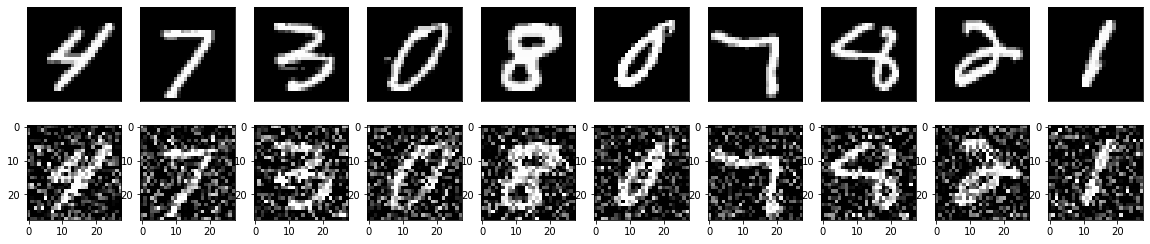

In [2]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

#Build the autoencoder

Convolution Layer와 MaxPooling을 2번 반복해서 인코더를 생성하고, 
디코더는 Conv2DTranspose 를 같은 횟수만큼 사용하도록 한다. 

In [3]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248  

위 구조를 바탕으로 오토인코더를 훈련시킨다.<br>
validation data는 따로 분리하지 않고, test_data를 그대로 사용하였다.<br>
이 단계에서는 바로 노이즈 이미지를 사용하지 않았고, 원본이 예측값과 얼마나 동일한지 보이기 위함이다.  

In [4]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 13s 10ms/step - loss: 0.1350 - val_loss: 0.0730
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0715 - val_loss: 0.0695
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0692 - val_loss: 0.0680
Epoch 4/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0680 - val_loss: 0.0672
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0673 - val_loss: 0.0664
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0667 - val_loss: 0.0660
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0662 - val_loss: 0.0656
Epoch 8/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0659 - val_loss: 0.0653
Epoch 9/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0655 - val_loss: 0.0650
Epoch 10/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0653 - val_loss: 0.06

313/313 [==============================] - 1s 2ms/step


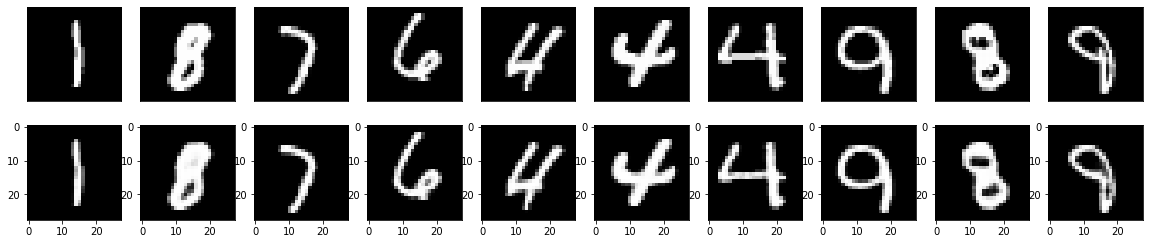

In [5]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

위의 결과로 오토인코더가 작동하는 것을 확인하면, 이제 노이즈 이미지를 입력으로 사용해 재훈련 시킨다. 

In [6]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 [==============================] - 4s 8ms/step - loss: 0.1015 - val_loss: 0.0941
Epoch 2/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0937 - val_loss: 0.0918
Epoch 3/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0920 - val_loss: 0.0905
Epoch 4/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0909 - val_loss: 0.0897
Epoch 5/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0902 - val_loss: 0.0896
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0896 - val_loss: 0.0885
Epoch 7/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0891 - val_loss: 0.0886
Epoch 8/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0887 - val_loss: 0.0877
Epoch 9/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0883 - val_loss: 0.0878
Epoch 10/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0880 - val_lo

313/313 [==============================] - 1s 2ms/step


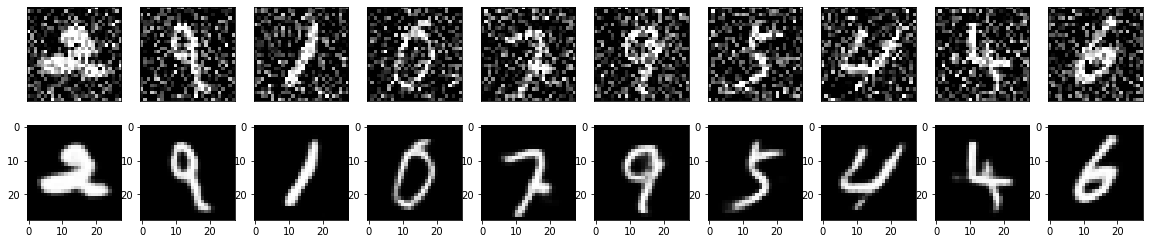

In [9]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

#확장

- 컬러 이미지의 노이즈 제거 오토 인코더의 설계는 어떻게 하면 좋을까? 
- 노이즈 제거에 특화된 최근의 다른 모델이 있는지<br> 
  -> Nvidia 노이즈가 심한 영상이나 워터마크 제거 